In [4]:
import warnings
warnings.filterwarnings( "ignore" )

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from IPython.display import Image

In [5]:
is_sep = False

while not is_sep:
    samples = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1)
    green = samples[0][samples[1] == 0]
    red = samples[0][samples[1] == 1]
    is_sep = any([red[:, k].max() < green[:, k].min() or red[:, k].min() > green[:, k].max() for k in range(2)])

X_train, X_test, Y_train, Y_test = train_test_split(samples[0], samples[1], test_size = 0.2, random_state = 123)

# Логистическая регрессия

Конечным результатом задачи классификации является разбиение множества объектов на классы. Давайте усложним задачу и будем предсказывать не конкретные классы, а вероятности принадлежать им, например, для бинарной классификации мы будем предсказывать одно число, которое будет соответствовать вероятности принадлежать положительному классу. \
Такого результата можно достичь, если мы будем строить линейную регрессию над некоторыми признаками, а затем её результат переводить в отрезок $[0;1]$. В этом нам поможет сигмоидная функция, которая имеет вид:
<p style="text-align: center;"> $f(z) = \dfrac{1}{1 + e^{-z}}$ </p>

![sigmoid.webp](https://cmertin.github.io/images/2016/11/11_17-Loan_Approvals/Sigmoid_Function.png)
<p style="text-align: center;"></p>

Моделью логистической регрессии назовём функцию от весов и объекта вида:

<p style="text-align: center;"> $a(w, x) = \dfrac{1}{1 + e^{-w_0 - w_1x_1 + ... + w_mx_m}}$ </p>

Обучение данной модели происходит за счет кросс-энтропийной или логистическая функции потерь :
<p style="text-align: center;"> $-\sum\limits_{i=1}^{n}(y_ilog(a_i) + (1 - y_i)log(1 - a_i))$ </p>
где $a_i = a(w, x_i)$

#### Задание №1. Выведите шаг градиентного спуска для логистической функции потерь (приложить фото)

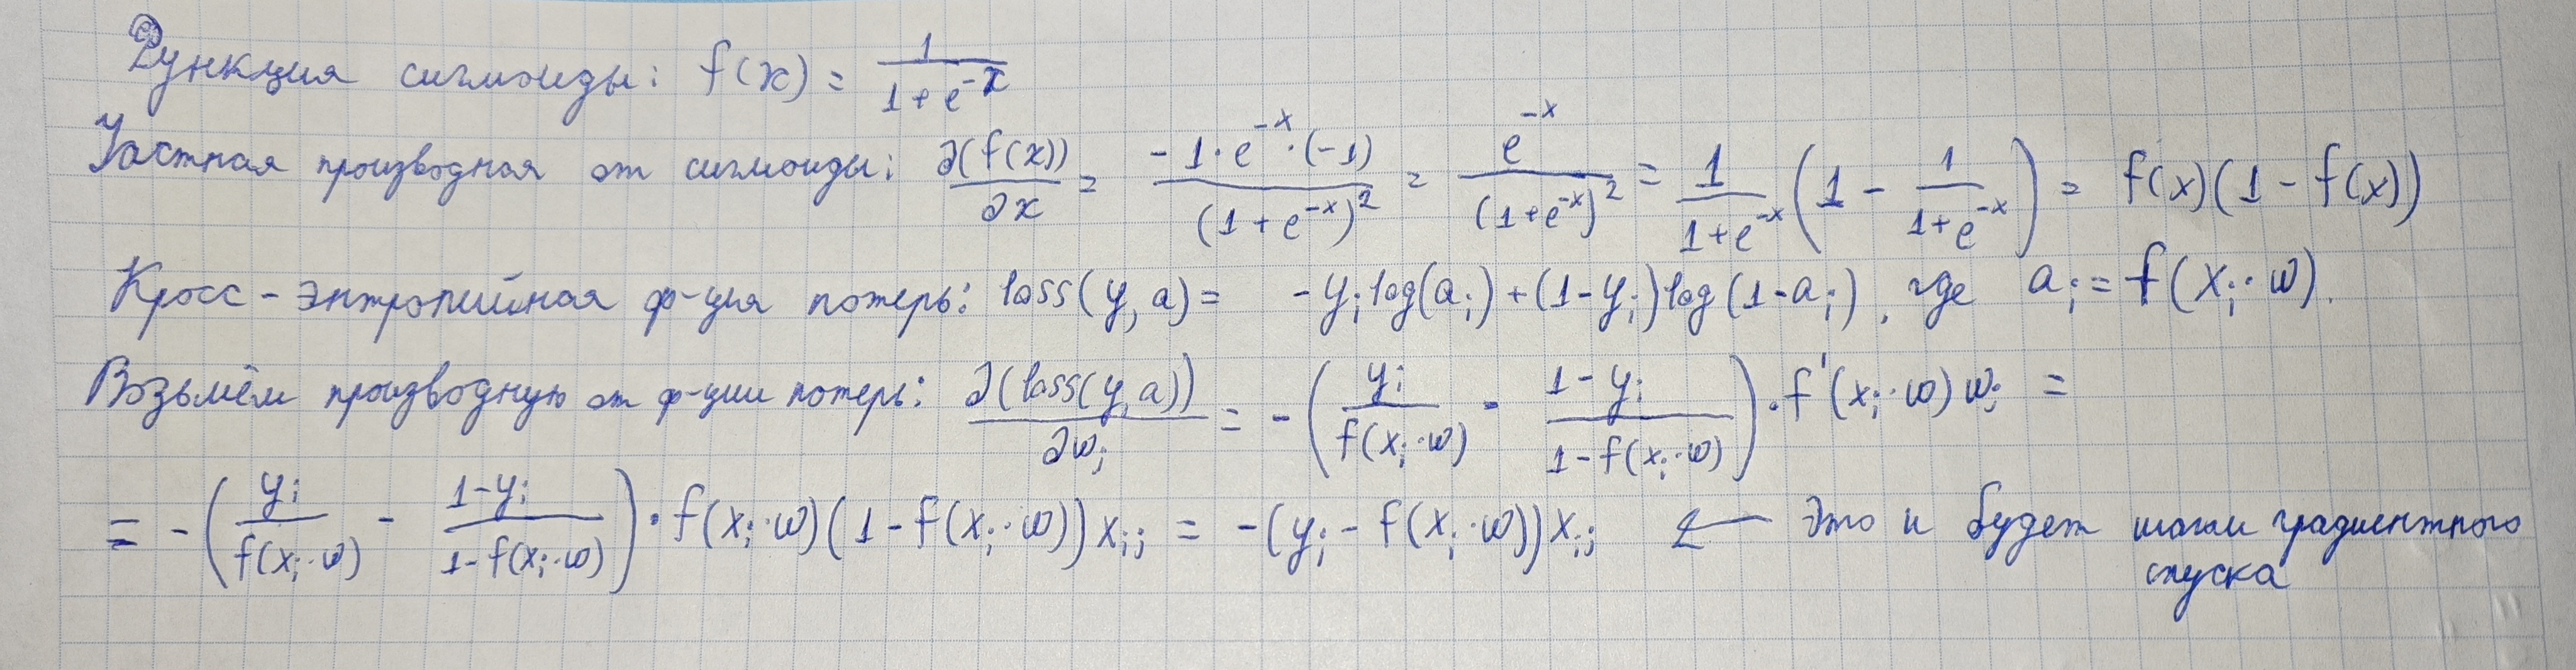

In [12]:
Image('./Formula.jpg')

In [7]:
def stepGD(W, X, Y, lr):
    a = 1 / (1 + np.exp(- X.dot(W)))    
    val = (a - Y.T)        
    val = np.reshape(val, X.shape[0])        
    dW = np.dot(X.T, val) / X.shape[0]         
    W = W - lr * dW

#### Задание №2. Напишите собственную логистическую регрессию

In [8]:
class MyLogRegression() :
    def __init__(self, learning_rate=0.01, num_steps=1000) :        
        self.learning_rate = learning_rate        
        self.num_steps = num_steps
            
    def fit(self, X, Y) :              
        self.m, n = X.shape             
        self.W = np.zeros(n)
        self.X = X        
        self.Y = Y               
        for _ in range(self.num_steps) :            
            self.step()            
      
    def step(self) :           
        a = 1 / (1 + np.exp(- self.X.dot(self.W)))    
        dif = (a - self.Y.T)        
        dif = np.reshape(dif, self.m)        
        dW = np.dot(self.X.T, dif) / self.m         
        self.W = self.W - self.learning_rate * dW    

    def predict(self, X) :    
        z = 1 / (1 + np.exp(- (X.dot(self.W))))        
        ans = np.where( z > 0.5, 1, 0 )        
        return ans

#### Задание №3. Сравните свою логистическую регрессию с аналогичной моделью из sklearn на сгенерированном датасете, опираясь на Accuracy. Баллы за задание: 10 - Accuracy > 99, 5 - Accuracy > 85, 0 - иначе

In [9]:
model = MyLogRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(f'My log regression score: {accuracy_score(Y_test, Y_pred)}')

modelCheck = LogisticRegression()
modelCheck.fit(X_train, Y_train)
Y_pred = modelCheck.predict(X_test)
print(f'Sklearn regression score: {accuracy_score(Y_test, Y_pred)}')

My log regression score: 1.0
Sklearn regression score: 1.0
